In [4]:
import matplotlib.pyplot as plt
import numpy.ma as ma
import json
import numpy as np
import pandas as pd

In [20]:
def read_results(results_file_name):
  results = []
  with open(results_file_name, 'r') as f:
    for line in f.readlines():
      if 'FeCAM:' in line:
        line = line.replace('\'', '"')
        result_json = line[line.index('{'):]
        result_dict = json.loads(result_json)
        result_list = list(result_dict.values())
        total = result_list[0]
        tens = result_list[1:-2]
        old_new = result_list[-2:]
        result_pad_list = [total] + tens + [0]*(10 - len(tens)) + old_new
        results.append(result_pad_list)

  results = np.array(results)
  results = results[:, 1:-2]
  means = results[:, :5].mean(axis=1).reshape((-1,1))
  results = results[:, 5:]
  results = np.concatenate((means, results), axis=1)
  return results


In [21]:
def print_results_chart(results_file_name, name):
    results = read_results(results_file_name)
    mask = np.triu(np.ones_like(results), k=1)
    masked_array = ma.masked_where(mask, results)

    plt.imshow(masked_array, cmap='Oranges', interpolation='nearest', vmin=0, vmax=100)

    for i in range(results.shape[0]):
        for j in range(results.shape[1]):
            if not mask[i, j]:
                plt.text(j, i, f'{results[i, j]:.2f}', ha='center', va='center', color='black', fontsize=9)

    plt.ylabel('after task')
    plt.xlabel('task acc')
    plt.title(name)
    plt.show()

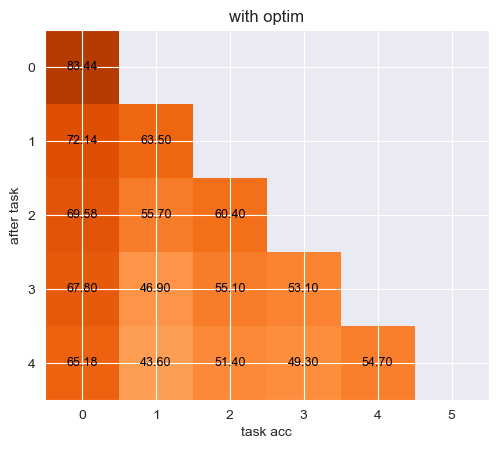

In [22]:
print_results_chart('./logs/with_optim.log', 'with optim')

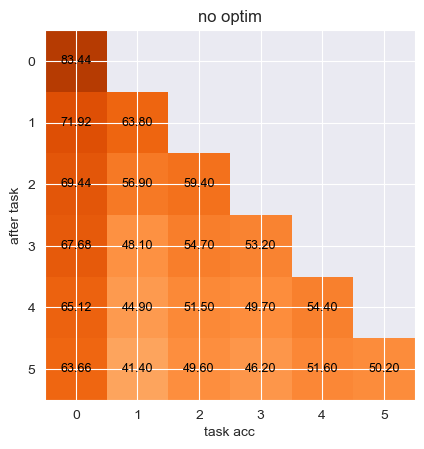

In [16]:
print_results_chart('./logs/no_optim.log', 'no optim')

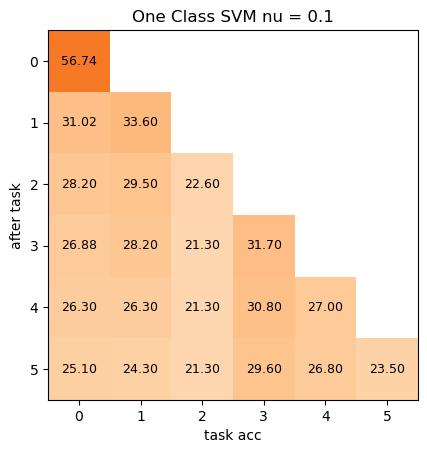

In [7]:
print_results_chart('./results/ocsvm-first-run0_1.txt', 'One Class SVM nu = 0.1')

# OCSVM

Results when all the OCSVMs for each class were parametrized the same way

In [8]:
def split_into_docs(output):
    return output.split('=========================================')

In [9]:
with open('./results/ocsvm_grid.txt', 'r') as f:
    content = f.read()
    docs = content.split('=========================================')
    docs = docs[1:] # pierwszy jest pusty
    param_lines = []
    acc_lines = []
    for doc in docs:
        fecam_line_found = False
        for line in doc.split('\n'):
            line = line.replace('\'', '"')
            if line.startswith('nu:'):
                param_line = line
            if 'FeCAM:' in line and not fecam_line_found:
                fecam_line = line.split('=>')[1][8:]
                fecam_line_found = True
        param_lines.append(param_line)
        acc_lines.append(json.loads(fecam_line)['total'])

print(param_lines[np.argmax(acc_lines)])
print(acc_lines[np.argmax(acc_lines)])

nu: 0.3, gamma: 0.01, kernel: poly
83.52


In [10]:
grid_results = [] # nu, gamma, kernel, acc
print(len(param_lines), len(acc_lines))
for param_line, acc in zip(param_lines, acc_lines):
    split = param_line.split(' ')
    nu = split[1][:-1]
    gamma = split[3][:-1]
    kernel = split[5]
    grid_results.append([nu, gamma, kernel, acc])

grid_results = np.array(grid_results)

144 144


In [11]:
import seaborn as sns

def draw_heatmap(kernel):
    filtered_data = grid_results[grid_results[:, 2] == kernel]
    # Convert the numerical values to float
    data_numeric = filtered_data[:, [0, 1, 3]].astype(float)

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 8))
    heatmap_data = data_numeric[:, 2].reshape(8, 6)
    xticks_labels = sorted(np.unique(data_numeric[:, 0]))
    yticks_labels = sorted(np.unique(data_numeric[:, 1]))

    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=yticks_labels, yticklabels=xticks_labels)

    plt.xlabel('Gamma')  # switch x-axis label to Column 2
    plt.ylabel('Nu')  # switch y-axis label to Column 1
    plt.title(f'Heatmap for kernel = {kernel}')

    plt.show()

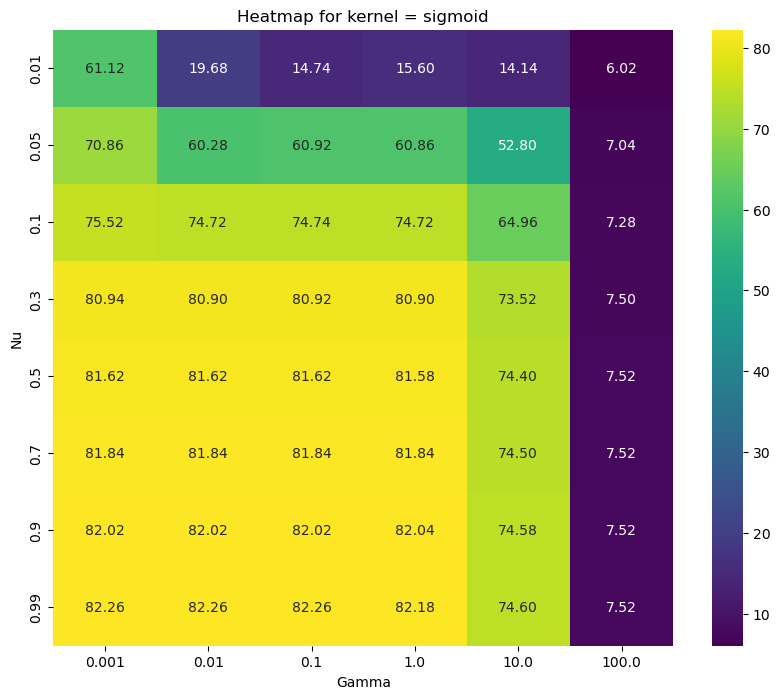

In [12]:
draw_heatmap('sigmoid')

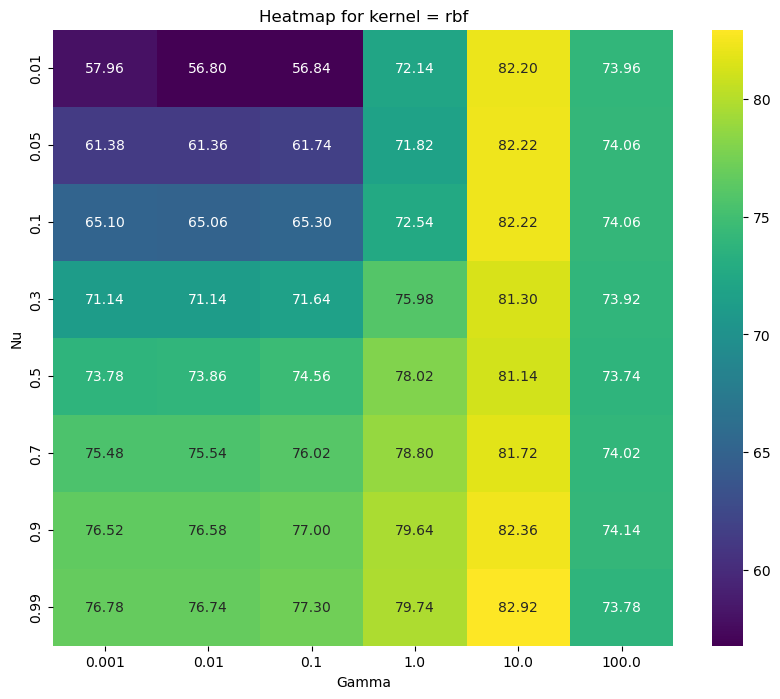

In [13]:
draw_heatmap('rbf')

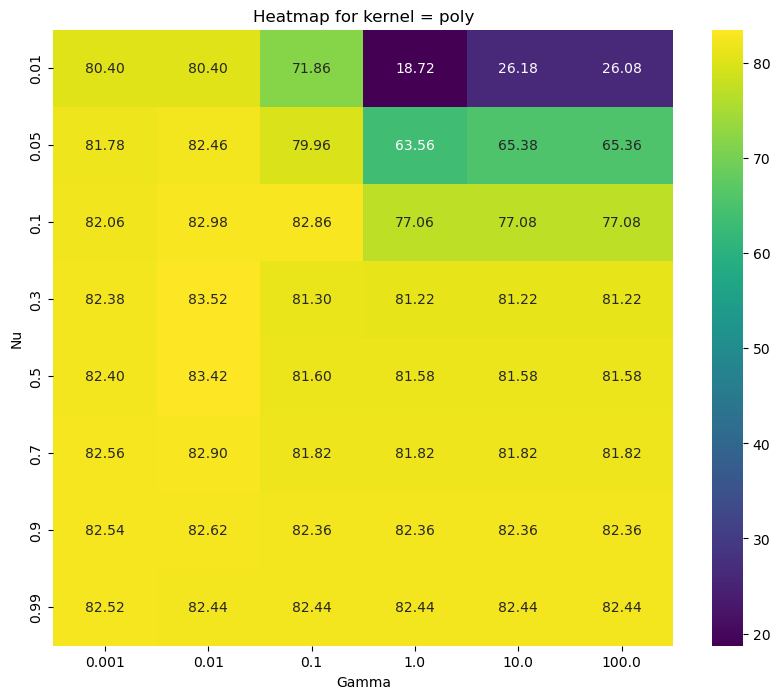

In [14]:
draw_heatmap('poly')

Bardziej dokładne przeszukanie gammy dla OCSVM

In [15]:
import torch
a = torch.tensor([1,2,3])
torch.argmax(a).item()

2

ocsvm_rbf_grid_one_for_each.txt

In [16]:
elliptic envelope
FeCAM: {'total': 47.97, '00-09': 79.2, '10-19': 70.0, '20-29': 72.3, '30-39': 70.7, '40-49': 60.9, '50-59': 7.2, '60-69': 28.4, '70-79': 46.3, '80-89': 29.1, '90-99': 15.6, 'old': 51.57, 'new': 15.6}
FeCAM top1 curve: [80.76, 69.55, 62.06, 56.19, 51.89, 47.97]

SyntaxError: invalid syntax (2763221221.py, line 1)

In [ ]:
one class svm
FeCAM: {'total': 49.01, '00-09': 82.8, '10-19': 74.9, '20-29': 80.4, '30-39': 76.1, '40-49': 80.2, '50-59': 19.3, '60-69': 25.5, '70-79': 19.3, '80-89': 14.5, '90-99': 17.1, 'old': 52.56, 'new': 17.1}
FeCAM top1 curve: [83.28, 70.93, 63.99, 57.91, 52.79, 49.01]

SyntaxError: invalid syntax (4106625718.py, line 2)

In [ ]:
mahalanobis (base)
FeCAM top1 curve: [83.44, 76.5, 72.64, 68.22, 64.91, 62.45]
FeCAM: {'total': 62.45, '00-09': 81.1, '10-19': 74.2, '20-29': 79.7, '30-39': 75.8, '40-49': 76.7, '50-59': 40.4, '60-69': 52.1, '70-79': 44.2, '80-89': 48.8, '90-99': 51.5, 'old': 63.67, 'new': 51.5}

In [17]:
import pandas as pd

In [18]:
print('Porównanie accuracy na poszczególnych taskach. Accuracy wyliczone \
dla każdego taska zaraz po nauczeniu tego taska.')

pd.DataFrame(
  [
    [80.76, 69.55, 62.06, 56.19, 51.89, 47.97],
    [83.28, 70.93, 63.99, 57.91, 52.79, 49.01],
    [82.16, 68.82, 62.57, 56.92, 52.59, 49.26],
    [83.44, 76.5, 72.64, 68.22, 64.91, 62.45]
  ],
  ['Elliptic Envelope', 'One-class SVM', 'Isolation Forest', 'Mahalanobis (base)'],
  ['Task 0', 'Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5']
)

Porównanie accuracy na poszczególnych taskach. Accuracy wyliczone dla każdego taska zaraz po nauczeniu tego taska.


,Task 0,Task 1,Task 2,Task 3,Task 4,Task 5
Elliptic Envelope,80.76,69.55,62.06,56.19,51.89,47.97
One-class SVM,83.28,70.93,63.99,57.91,52.79,49.01
Isolation Forest,82.16,68.82,62.57,56.92,52.59,49.26
Mahalanobis (base),83.44,76.50,72.64,68.22,64.91,62.45


In [19]:
print('Ewaluacja accuracy na końcu, po nauczeniu wszystkich tasków. "total" oznacza średnie accuracy, \
kolejne kolumny zawierają accuracy dla danych 10 klas, "old" oznacza accuracy dla klas 00-89, "new" oznacza \
accuracy dla klas 90-99 (ostatni task).')

pd.DataFrame(
  [
    [47.97, 79.2, 70.0, 72.3, 70.7, 60.9, 7.2, 28.4, 46.3, 29.1, 15.6, 51.57, 15.6],
    [49.01, 82.8, 74.9, 80.4, 76.1, 80.2, 19.3, 25.5, 19.3, 14.5, 17.1, 52.56, 17.1],
    [49.26, 71.9, 64.1, 68.9, 65.0, 62.8, 24.2, 27.5, 33.2, 32.5, 42.5, 50.01, 42.5],
    [62.45, 81.1, 74.2, 79.7, 75.8, 76.7, 40.4, 52.1, 44.2, 48.8, 51.5, 63.67, 51.5]
  ],
  ['Elliptic Envelope', 'One-class SVM', 'Isolation Forest', 'Mahalanobis (base)'],
  ['total', '00-09', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', 'old', 'new']
)

Ewaluacja accuracy na końcu, po nauczeniu wszystkich tasków. "total" oznacza średnie accuracy, kolejne kolumny zawierają accuracy dla danych 10 klas, "old" oznacza accuracy dla klas 00-89, "new" oznacza accuracy dla klas 90-99 (ostatni task).


,total,00-09,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99,old,new
Elliptic Envelope,47.97,79.2,70.0,72.3,70.7,60.9,7.2,28.4,46.3,29.1,15.6,51.57,15.6
One-class SVM,49.01,82.8,74.9,80.4,76.1,80.2,19.3,25.5,19.3,14.5,17.1,52.56,17.1
Isolation Forest,49.26,71.9,64.1,68.9,65.0,62.8,24.2,27.5,33.2,32.5,42.5,50.01,42.5
Mahalanobis (base),62.45,81.1,74.2,79.7,75.8,76.7,40.4,52.1,44.2,48.8,51.5,63.67,51.5


In [20]:
# Średnia z top1 dla Mahalanobisa
np.mean([83.44, 76.5, 72.64, 68.22, 64.91, 62.45])

71.35999999999999

In [21]:
# Średnia z top1 dla One Class SVM
np.mean([83.28, 70.93, 63.99, 57.91, 52.79, 49.01])

62.98500000000001

In [4]:
print('Porównanie accuracy na poszczególnych taskach. Accuracy wyliczone \
dla każdego taska zaraz po nauczeniu tego taska.')

pd.DataFrame(
  [
    [80.76, 69.55, 62.06, 56.19, 51.89, 47.97],
    [79.06, 65.83, 56.91, 49.85, 44.4, 40.14],
    [83.28, 70.93, 63.99, 57.91, 52.79, 49.01],
    [83.74, 71.78, 63.71, 56.88, 50.97, 47.25],
    [82.16, 68.82, 62.57, 56.92, 52.59, 49.26],
    [83.44, 76.5, 72.64, 68.22, 64.91, 62.45]
  ],
  ['Elliptic Envelope', 'Elliptic Envelope z normalizacją', 'One-class SVM', 'One-class SVM z normalizacją (rerun)', 'Isolation Forest', 'Mahalanobis (base)'],
  ['Task 0', 'Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5']
)

Porównanie accuracy na poszczególnych taskach. Accuracy wyliczone dla każdego taska zaraz po nauczeniu tego taska.


,Task 0,Task 1,Task 2,Task 3,Task 4,Task 5
Elliptic Envelope,80.76,69.55,62.06,56.19,51.89,47.97
Elliptic Envelope z normalizacją,79.06,65.83,56.91,49.85,44.40,40.14
One-class SVM,83.28,70.93,63.99,57.91,52.79,49.01
One-class SVM z normalizacją (rerun),83.74,71.78,63.71,56.88,50.97,47.25
Isolation Forest,82.16,68.82,62.57,56.92,52.59,49.26
Mahalanobis (base),83.44,76.50,72.64,68.22,64.91,62.45


In [5]:
print('Ewaluacja accuracy na końcu, po nauczeniu wszystkich tasków. "total" oznacza średnie accuracy, \
kolejne kolumny zawierają accuracy dla danych 10 klas, "old" oznacza accuracy dla klas 00-89, "new" oznacza \
accuracy dla klas 90-99 (ostatni task).')

pd.DataFrame(
  [
    [47.97, 79.2, 70.0, 72.3, 70.7, 60.9, 7.2, 28.4, 46.3, 29.1, 15.6, 51.57, 15.6],
    [40.14, 76.8, 62.1, 74.8, 73.4, 70.7, 0.4, 39.8, 0.8, 0.8, 1.8, 44.4, 1.8],
    [49.01, 82.8, 74.9, 80.4, 76.1, 80.2, 19.3, 25.5, 19.3, 14.5, 17.1, 52.56, 17.1],
    [41.51, 80.4, 70.0, 75.4, 67.2, 71.5, 6.5, 9.5, 8.5, 16.6, 9.5, 45.07, 9.5],
    [49.26, 71.9, 64.1, 68.9, 65.0, 62.8, 24.2, 27.5, 33.2, 32.5, 42.5, 50.01, 42.5],
    [62.45, 81.1, 74.2, 79.7, 75.8, 76.7, 40.4, 52.1, 44.2, 48.8, 51.5, 63.67, 51.5]
  ],
  ['Elliptic Envelope', 'Elliptic Envelope z normalizacją', 'One-class SVM', 'One-class SVM z normalizacją', 'Isolation Forest', 'Mahalanobis (base)'],
  ['total', '00-09', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', 'old', 'new']
)

Ewaluacja accuracy na końcu, po nauczeniu wszystkich tasków. "total" oznacza średnie accuracy, kolejne kolumny zawierają accuracy dla danych 10 klas, "old" oznacza accuracy dla klas 00-89, "new" oznacza accuracy dla klas 90-99 (ostatni task).


,total,00-09,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99,old,new
Elliptic Envelope,47.97,79.2,70.0,72.3,70.7,60.9,7.2,28.4,46.3,29.1,15.6,51.57,15.6
Elliptic Envelope z normalizacją,40.14,76.8,62.1,74.8,73.4,70.7,0.4,39.8,0.8,0.8,1.8,44.40,1.8
One-class SVM,49.01,82.8,74.9,80.4,76.1,80.2,19.3,25.5,19.3,14.5,17.1,52.56,17.1
One-class SVM z normalizacją,41.51,80.4,70.0,75.4,67.2,71.5,6.5,9.5,8.5,16.6,9.5,45.07,9.5
Isolation Forest,49.26,71.9,64.1,68.9,65.0,62.8,24.2,27.5,33.2,32.5,42.5,50.01,42.5
Mahalanobis (base),62.45,81.1,74.2,79.7,75.8,76.7,40.4,52.1,44.2,48.8,51.5,63.67,51.5


In [6]:
from sklearn.svm import OneClassSVM
X = [[0], [0.44], [0.45], [0.46], [1]]
clf = OneClassSVM(gamma='auto').fit(X)
clf.predict(X)

array([-1,  1,  1,  1, -1])

In [7]:
clf.decision_function(X)

array([-2.74925564e-01,  5.28455635e-09,  8.06251090e-04,  1.35696904e-03,
       -3.21513634e-01])

In [8]:
clf.score_samples(X)

array([1.77987316, 2.05479873, 2.05560497, 2.05615569, 1.73328509])